# 0. Overview

#### 1. Load Spotify Data

#### 2. Preprocessing - Stage One
a. Define target variable <br>
b. Train-test-split <br>

#### 3. Feature Engineering
a. Extract song genres from song_tag<br>
b. Extract artist types from artist_tag <br>
c. Extract chorus and verse features from raw Lyrics <br>
d. Extract Lyrics features <br>
e. TF-IDF for Lyrics<br>
f. LDA for Lyrics<br>
g. Artist level<br>

#### 4. Preprocessing - Stage Two
a. Impute missing value <br>
b. Feature selection <br>
c. Sklearn pipeline <br>

#### 5. Models
a. Logistic Regression <br>
b. SVM <br>
c. Random forest <br>
d. Xgboost <br>

#### 6. Insights
a. ROC <br>
b. Feature importance <br>

# 1. Load Spotify Data

In [1]:
import pandas as pd

In [2]:
class Config:
    
    root_dir = 'D:\\Job\\Codes\\Data\\'
    data_dir = root_dir + 'spotify.xlsx'

config = Config

In [3]:
data = pd.read_excel(config.data_dir, encoding = 'ISO-8859-1')

- There are 3576 unique songs and 18 features

In [4]:
data.shape

(3576, 17)

- This 18 raw features include song title, lyrics, artist, tag and 8 audio features

In [5]:
data.head()

,Days,Pk.,Lyrics,Title,Artist,artist_tag,song_tag,releaseYear,releaseMonth,acousticness,danceability,energy,liveness,loudness,speechiness,Tempo,valence
0,622,1,"[Intro: Kyla]\nBaby, I like your style\n[Verse...",One Dance,Drake,"hip-hop,rap,hip hop,rnb,drake,canadian","ovo,kyla,wizkid,pop,drake,aubrey",2016,5,0.00902,0.785,0.617,0.351,-5.871,0.0522,103.981,0.382
1,544,1,"[Verse 1: Andrew Taggart] Hey, I was doing jus...",Closer,The Chainsmokers,"electronic,pop,house,electro house,dance,american","2016,halsey,pop,electropop,,",2016,7,0.41400,0.748,0.524,0.111,-5.599,0.0338,95.010,0.661
2,305,1,[Video Intro] Wicked or weakness?\nYou gotta s...,HUMBLE,Kendrick Lamar,"hip-hop,rap,west coast,hip hop,compton,fip","rap,hip-hop,,,,",2017,9,0.00778,0.898,0.935,0.217,-2.744,0.2910,150.016,0.884
3,312,1,"[Intro] Are you alright?\nI'm alright, I'm qui...",XO TOUR Llif3,Lil Uzi Vert,"hip-hop,trap,yeah,rap,american,trap rap","rap,american,emo rap,xo,trap,2017",2017,8,0.00466,0.722,0.614,0.106,-7.549,0.1150,154.903,0.485
4,417,5,"[Intro: Post Malone]\nMm-mmm\nYah, yah\nMm-mmm...",Congratulations,Post Malone,"hip-hop,rap,cloud rap,hip hop,trap,pop rap","rap,hip hop,trap,2017,quavo,superbowl call dem...",2017,6,0.19500,0.522,0.726,0.493,-4.460,0.1540,123.017,0.491


# 2. Preprocessing - Stage One

### a. Define target variable

- Our question is that what kinds of song could be popular for a long time
- In the dataset, **Days** and **Pk.** provide such information:
    1. **Pk.**: the highest ranking the song ever reached (1 stands for top 1)
    2. **Days**: the days the song stay in the top 200 songs
    
    
- So we will use K-Means to cluster all 3576 songs with **Pk.** and **Days** to define popular songs

- Take wanted subset of whole data and split it to training and testing set

In [6]:
import numpy as np
from sklearn.preprocessing import StandardScaler

In [7]:
def df_for_kmeans(data, cols):
    
    """
    Args:
        data (pandas dataframe): Dataset for K-Means
        cols (list): A list contains the name of column used for K-Means
        
    Returns:
        X_train (pandas dataframe): Traing subset for K-Means
        X_test (pandas dataframe): Testing subset for K-Means
    """
    
    np.random.seed(1)
    # sample 70% as training set
    X_train = data.loc[:, cols].sample(frac = 0.7).copy()
    # the rest 30% as testing set
    X_test = data.loc[~data.index.isin(X_train.index), cols].copy()
    
    # scaling
    Sc = StandardScaler()
    X_train.loc[:, :] = Sc.fit_transform(X_train.astype('float64'))
    X_test.loc[:, :] = Sc.transform(X_test.astype('float64'))
    
    return X_train, X_test

X_train_km, X_test_km = df_for_kmeans(data, ['Pk.', 'Days'])

- loop over K-Means n_clusters from 2 to 10 to search for optimal n_clusters
- for each n_cluster, retain the corresponding sum of squared within-group distance to evaluate performance later

In [8]:
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt

def kmeans_dist(X_train, X_test, maxk = 10):
    
    """
    Args:
        maxk (int): The maximum n_clusters wanted to try
        X_train (pandas dataframe): Traing set for K-Means
        X_test (pandas dataframe): Testing set for K-Means
        
    Returns:
        train_scores (list): Training Set's sum of squared within-group distance for each n_clusters
        test_scores (list): Test Set's sum of squared within-group distance for each n_clusters
    """
    
    # initialize list
    train_scores = []
    test_scores = []
    
    # loop over candidate n_clusters
    for k in range(2, maxk):
        
        # fit the K-Means model
        km = KMeans(n_clusters = k, n_init = 100, random_state = 1)
        km.fit(X_train)
        # append the score to lists
        train_scores.append(-km.score(X_train))
        test_scores.append(-km.score(X_test))
        
    return train_scores, test_scores

train_scores, test_scores = kmeans_dist(X_train_km, X_test_km, maxk = 10)

- Then we could plot the distance to search for optimal n_clusters
- Ideally, n_clusters should be selecte at the steepest point

In [9]:
def plot_kmeans_dist(train_scores, test_scores):
    
    """
    Args:
        train_scores (list): Training Set's sum of squared within-group distance for each n_clusters
        test_scores (list): Test Set's sum of squared within-group distance for each n_clusters
        
    Returns:
        None
    """
    
    fig, ax = plt.subplots(1, 1, figsize = (10, 8))

    l1 = sns.lineplot(x = np.arange(2, 10),
                      y = train_scores,
                      ax = ax)

    l2 = sns.lineplot(x = np.arange(2, 10),
                      y = test_scores, 
                      ax = ax)
    
    ax.legend(['Train', 'Test'])
    ax.set_xlabel('Cluster Number')
    ax.set_ylabel('Sum of Square Distance')

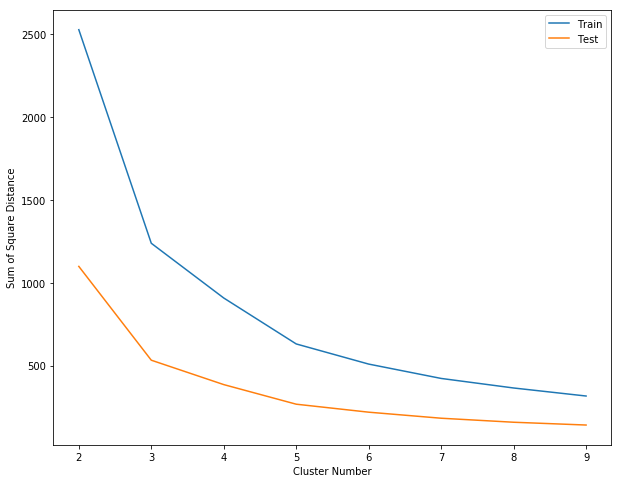

In [10]:
plot_kmeans_dist(train_scores, test_scores)

- From the plotting above, we could see that cluster number as 5 could be the optimal choice
- The reason is that the within-group distance barely decrease when cluster number is larger than 5

In [11]:
def clustering(data):
    
    """
    Args:
        data (pandas dataframe): Dataset for K-Means
    
    Returns:
        data (pandas dataframe): Dataset with clusters
    """
    
    # take subset from whole dataset to train K-Means
    data_subset = data.loc[:, ['Pk.', 'Days']].copy()
    
    # scaling
    Sc = StandardScaler()
    data_subset.loc[:, :] = Sc.fit_transform(data_subset.astype('float64'))
    
    # fit the K-Means with optimal cluster number of 5
    km = KMeans(n_clusters = 5, n_init = 100, random_state = 1)
    # cluster for whole dataset
    data['cluster'] = km.fit_predict(data_subset)

    # plot
    sct = sns.pairplot(data = data,
                       height = 5,
                       aspect = 1.5,
                       x_vars = 'Pk.',
                       y_vars = 'Days',
                       hue = 'cluster')
    
    return data

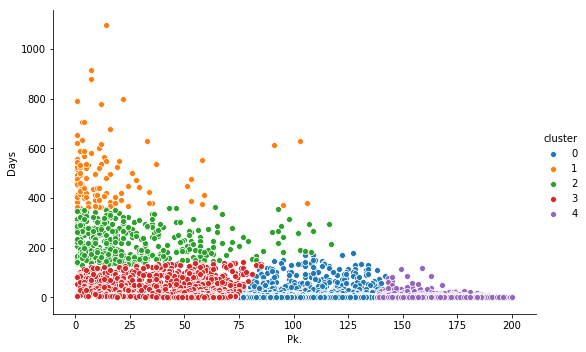

In [12]:
data = clustering(data)

- From the plotting above, we could find that songs of **group1** and **group2** are both popular (reach the top ranking) and for a long time (more than about 150 days)
- Songs of **group0** and **group4** are not super popular as songs of **group1** and **group2**, and stay in top200 board only for a relatively short period
- Songs of **group3** are popular but, for some reasons, do not stay in top200 board for a long time.
- As a result, we will define songs of **group1** and **group2** as songs popular for a long time, whereas songs of **group0**, **group3** and **group4** are not.

In [13]:
data['Popular'] = data.cluster.map({0:0, 1:1, 2:1, 3:0, 4:0})
data.drop(['Days', 'Pk.', 'cluster'], axis = 1, inplace = True)
data['Popular'].value_counts(normalize = True)

0    0.852629
1    0.147371
Name: Popular, dtype: float64

In [14]:
data.head()

,Lyrics,Title,Artist,artist_tag,song_tag,releaseYear,releaseMonth,acousticness,danceability,energy,liveness,loudness,speechiness,Tempo,valence,Popular
0,"[Intro: Kyla]\nBaby, I like your style\n[Verse...",One Dance,Drake,"hip-hop,rap,hip hop,rnb,drake,canadian","ovo,kyla,wizkid,pop,drake,aubrey",2016,5,0.00902,0.785,0.617,0.351,-5.871,0.0522,103.981,0.382,1
1,"[Verse 1: Andrew Taggart] Hey, I was doing jus...",Closer,The Chainsmokers,"electronic,pop,house,electro house,dance,american","2016,halsey,pop,electropop,,",2016,7,0.41400,0.748,0.524,0.111,-5.599,0.0338,95.010,0.661,1
2,[Video Intro] Wicked or weakness?\nYou gotta s...,HUMBLE,Kendrick Lamar,"hip-hop,rap,west coast,hip hop,compton,fip","rap,hip-hop,,,,",2017,9,0.00778,0.898,0.935,0.217,-2.744,0.2910,150.016,0.884,1
3,"[Intro] Are you alright?\nI'm alright, I'm qui...",XO TOUR Llif3,Lil Uzi Vert,"hip-hop,trap,yeah,rap,american,trap rap","rap,american,emo rap,xo,trap,2017",2017,8,0.00466,0.722,0.614,0.106,-7.549,0.1150,154.903,0.485,1
4,"[Intro: Post Malone]\nMm-mmm\nYah, yah\nMm-mmm...",Congratulations,Post Malone,"hip-hop,rap,cloud rap,hip hop,trap,pop rap","rap,hip hop,trap,2017,quavo,superbowl call dem...",2017,6,0.19500,0.522,0.726,0.493,-4.460,0.1540,123.017,0.491,1


### b. train-test-split

In [15]:
from sklearn.model_selection import train_test_split

In [16]:
X, y = data.iloc[:, :-1].copy(), data.Popular.copy()

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.3,
                                                    stratify = y,
                                                    random_state = 1)

In [17]:
print('Training Set Shape: ', X_train.shape)
print('Test Set Shape: ',X_test.shape)

Training Set Shape:  (2503, 15)
Test Set Shape:  (1073, 15)


# 3. Feature Engineering

### a. Extract song genres from song_tag

- In the dataset, **song_tag** provides the information about song genre
- However, it is messy that we need to clean it first
- We choose in total 15 genres to use by domain knowledge

In [18]:
from sklearn.feature_extraction.text import CountVectorizer

In [19]:
def clean_song_tag(data):
        
    """
    Args:
        data (pandas dataframe): Dataset with raw song_tag
    
    Returns:
        data (pandas dataframe): Dataset with new features
    """
    data = data.copy()
    
    # though some tags' naming are different, but actually they are the same genre
    data['song_tag'] = data.song_tag.str.replace('hip-hop','hiphop')
    data['song_tag'] = data.song_tag.str.replace('hip hop','hiphop')
    data['song_tag'] = data.song_tag.str.replace('r&b','rnb')
    data['song_tag'] = data.song_tag.str.replace('electronic','electro')
    
    # use CountVectorizer to build binary term-frequency matrix for song_tag
    vect = CountVectorizer(binary = True)
    termfreq = pd.DataFrame(vect.fit_transform(data.song_tag).toarray(), columns=vect.get_feature_names())
    
    # 15 song genres are selected by domain knowledge
    genre = ['pop', 'hiphop', 'rap', 'electro', 
             'rock', 'trap', 'rnb', 'alternative', 
             'dance', 'soul', 'indie', 'acoustic', 
             'country', 'funk', 'folk']
    
    # take only 15 genres
    termfreq = termfreq.loc[:, genre]
    
    # add preffix for song genre
    termfreq.columns = 'song_' + termfreq.columns
    
    # merge with main dataset
    data = pd.merge(left = data, 
                    right = termfreq, 
                    how  = 'left',
                    left_index = True,
                    right_index = True)
    
    # drop song_tag
    data.drop(['song_tag'], axis = 1, inplace = True)
    
    return data

X_train = clean_song_tag(X_train)
X_test = clean_song_tag(X_test)

### b. Extract aritst types from artist_tag

- Like **song_tag** above, **artist_tag** also provides information about artist
- We performance the same cleaning process above except that the selected artist types are different

In [20]:
def clean_artist_tag(data):
    
    """
    Args:
        data (pandas dataframe): Dataset with raw artist_tag
    
    Returns:
        data (pandas dataframe): Dataset with new features
    """
    data = data.copy()
    
    # though some tags' naming are different, but actually they are the same genre
    data['artist_tag'] = data.artist_tag.str.replace('hip-hop','hiphop')
    data['artist_tag'] = data.artist_tag.str.replace('hip hop','hiphop')
    data['artist_tag'] = data.artist_tag.str.replace('r&b','rnb')
    data['artist_tag'] = data.artist_tag.str.replace('electronic','electro')
    
    # use CountVectorizer to build binary term-frequency matrix for song_tag
    vect = CountVectorizer(binary = True)
    termfreq = pd.DataFrame(vect.fit_transform(data.artist_tag).toarray(), columns=vect.get_feature_names())
    
    # 15 artist genres are selected by domain knowledge
    genre = ['pop', 'hiphop', 'rap', 'rock', 
             'indie', 'vocalists', 'alternative', 'rnb', 
             'electro', 'dance', 'male', 'female', 
             'soul', 'songwriter', 'folk']
    
    # take only 15 genres
    termfreq = termfreq.loc[:, genre]
    
    # add preffix for artist
    termfreq.columns = 'art_' + termfreq.columns
    
    # merge with main dataset
    data = pd.merge(left = data, 
                    right = termfreq, 
                    how  = 'left',
                    left_index = True,
                    right_index = True)
    
    # drop artist_tag
    data.drop(['artist_tag'], axis = 1, inplace = True)
    
    return data

X_train = clean_artist_tag(X_train)
X_test = clean_artist_tag(X_test)

### c. Extract chorus and verse features from raw Lyrics

- Besides whole lyrics, the length or sentiment of chorus and verse  may be influential, so we will extract chorus and verse and perform text mining on them separately.

In [21]:
import re

In [22]:
def get_verse_doc(doc):
    
    """
    Args:
        doc (str): Whole lyrics with tags indicating each paragraph
        
    Returns:
        verse_doc (list): A list retains each verse paragraph
    """
    
    verse_doc = []
    
    # use regex to split all paragraph with retaining (Verse|Chorus|Outro|Intro|Hook)
    para_list = re.split(r'(\[[A-Za-z1-9.:+\s&$()?-]*(Verse|Chorus|Outro|Intro|Hook)+[A-Za-z1-9.:+\s&$()?-]*\])', doc)
    
    # store the element that follows Verse/Chorus
    for i, para in enumerate(para_list):
        
        if para == 'Verse':
            
            verse_doc.append(para_list[i + 1])
    
    return verse_doc

In [23]:
def get_chorus_doc(doc):
    
    """
    Args:
        doc (str): Whole lyrics with tags indicating each paragraph
        
    Returns:
        chorus_doc (list): A list retains each chorus paragraph
    """
    
    chorus_doc = []
    
    # use regex to split all paragraph with retaining (Verse|Chorus|Outro|Intro|Hook)
    para_list = re.split(r'(\[[A-Za-z1-9.:+\s&$()?-]*(Verse|Chorus|Outro|Intro|Hook)+[A-Za-z1-9.:+\s&$()?-]*\])', doc)
    
    # store the element that follows Verse/Chorus
    for i, para in enumerate(para_list):
        
        if para == 'Chorus':
            
            chorus_doc.append(para_list[i + 1])
    
    return chorus_doc

In [24]:
from textblob import TextBlob

In [25]:
def feature_eng_verse_chorus(data):
    
    """
    Args:
        data (pandas dataframe): Dataset with raw Lyrics
    
    Returns:
        data (pandas dataframe): Dataset with new features of verse/chorus
    """
    
    data = data.copy()
    
    # extract verse/chorus doc from Lyrics
    data['verse_doc'] = data.Lyrics.apply(get_verse_doc)
    data['chorus_doc'] = data.Lyrics.apply(get_chorus_doc)
    
    # extract verse/chorus paragraph number
    data['verse_num'] = data.verse_doc.apply(len)
    data['chorus_num'] = data.chorus_doc.apply(len)
    
    # extract verse/chorus length
    data['verse_len'] = data.verse_doc.apply(lambda x: len(''.join(x).split()))
    data['chorus_len'] = data.chorus_doc.apply(lambda x: len(''.join(x).split()))
    
    # sentiment analysis used pre-trained TextBlob library
    # could use more advanced model to do sentiment classification
    # polarity score ranges from -1 to 1 where -1 stands for negative sentiment and 1 stands for positive sentiment
    data['verse_polarity'] = data.verse_doc.apply(lambda x: TextBlob(''.join(x)).polarity)
    data['chorus_polarity'] = data.chorus_doc.apply(lambda x: TextBlob(''.join(x)).polarity)
    
    # subjectivity score ranges from -1 to 1 where -1 stands for objectivity and 1 stands for subjectivity
    data['verse_subjectivity'] = data.verse_doc.apply(lambda x: TextBlob(''.join(x)).subjectivity)
    data['chorus_subjectivity'] = data.chorus_doc.apply(lambda x: TextBlob(''.join(x)).subjectivity)
    
    # a feature telling if there is polarity twist between verse and chorus
    data['polarity_twist'] = np.where(data.verse_polarity * data.chorus_polarity < 0, 1, 0)
    
    # drop verse/chorus doc
    data.drop(['verse_doc', 'chorus_doc'], axis = 1, inplace = True)
    
    return data

X_train = feature_eng_verse_chorus(X_train)
X_test = feature_eng_verse_chorus(X_test)

### d. Extract Lyrics features

- We are also interested in whether the lyrics length will influence the popularity of the song
- However, **Lyrics** contains some text to indicate differnet paragraphs and singers, which needs to be first removed before extracting actual lyrics length

In [26]:
def feature_eng_lyrics(data):
    
    """
    Args:
        data (pandas dataframe): Dataset with raw Lyrics
    
    Returns:
        data (pandas dataframe): Dataset with new features of Lyrics
    """
    
    data = data.copy()
    
    # remove extra text
    data['Lyrics'] = data.Lyrics.apply(lambda x: re.sub('([\(\[]).*?([\)\]])', '\g<1>\g<2>', x))
    
    # sentiment analysis used pre-trained TextBlob library
    data['Lyrics_polarity'] = data.Lyrics.apply(lambda x: TextBlob(x).polarity)
    
    # subjectivity score ranges from -1 to 1 where -1 stands for objectivity and 1 stands for subjectivity
    data['Lyrics_subjectivity'] = data.Lyrics.apply(lambda x: TextBlob(x).subjectivity)
    
    # extract lyrics length
    data['Lyrics_len'] = data.Lyrics.apply(lambda x: len(x.split()))
    
    # extract unique word number to assess overall complexity
    data['Lyrics_complexity'] = data.Lyrics.apply(lambda x: len(set(x.split())))
    
    return data

X_train = feature_eng_lyrics(X_train)
X_test = feature_eng_lyrics(X_test)

- Besides length, complexity, polarity and subjectivity, we will perform TF-IDF & LDA text mining  as well
- To accurately perform tf-idf & LDA, some stop words, punctuation and lemmatization needs to be done first
- Whereas length, complexity, polarity and subjectivity should be implemented without removing those information.
- So we perform cleaning process after feature engineering of length, complexity, polarity and subjectivity 

- we utilize nltk's stopwords and spacy's nlp to do lemmatization

In [27]:
from nltk.corpus import stopwords 
import string
import en_core_web_sm

C:\Users\User\Anaconda3\envs\tensorflow_env\lib\importlib\_bootstrap.py:219: RuntimeWarning: cymem.cymem.Pool size changed, may indicate binary incompatibility. Expected 48 from C header, got 64 from PyObject
  return f(*args, **kwds)
C:\Users\User\Anaconda3\envs\tensorflow_env\lib\importlib\_bootstrap.py:219: RuntimeWarning: cymem.cymem.Address size changed, may indicate binary incompatibility. Expected 24 from C header, got 40 from PyObject
  return f(*args, **kwds)


In [28]:
def stop_words(doc):
    
    """
    Args:
        doc (str): lyrics
        
    Returns:
        stop_free (str): stopword-free lyrics
    """
    
    stop = set(stopwords.words('english'))
    stop_free = ' '.join([i for i in doc.lower().split() if i not in stop])
    
    return stop_free

In [29]:
def lemma(doc):
    
    """
    Args:
        doc (str): lyrics
        
    Returns:
        lem (str): lemmatized lyrics
    """
    
    # call english module
    nlp = en_core_web_sm.load()
    # fit doc
    words = nlp(doc)
    # initialize string to retain lemmatized words
    lem = ''
    
    for token in words:
        
        lem = lem + ' ' + token.lemma_
    
    return lem

In [30]:
# spacy lemmatization will take about 1.5s for each sample
def preprocess_lyrics(data):
    
    data = data.copy()
    
    # remove line breaker
    data['Lyrics'] = data.Lyrics.str.replace('\n', ' ')
    
    # remove punctuation, stop words and perform lemmatization
    regex = re.compile('[{0}]'.format(re.escape(string.punctuation)))
    data['Lyrics'] = data.Lyrics.apply(lambda x: lemma(stop_words(regex.sub('', x).lower().strip())))
    
    data['Lyrics'] = data.Lyrics.str.replace('-PRON-', '')
    
    return data


X_train = preprocess_lyrics(X_train)
X_test = preprocess_lyrics(X_test)

C:\Users\User\Anaconda3\envs\tensorflow_env\lib\importlib\_bootstrap.py:219: RuntimeWarning: cymem.cymem.Pool size changed, may indicate binary incompatibility. Expected 48 from C header, got 64 from PyObject
  return f(*args, **kwds)
C:\Users\User\Anaconda3\envs\tensorflow_env\lib\importlib\_bootstrap.py:219: RuntimeWarning: cymem.cymem.Address size changed, may indicate binary incompatibility. Expected 24 from C header, got 40 from PyObject
  return f(*args, **kwds)


### e. TF-IDF for Lyrics

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer

- We could utilize sklearn TfidfVectorizer to transform Lyrics to TF-IDF matrix
- But since there some parameters needs to be tuned in TfidfVectorizer, we will only call TfidfVectorizer here and later fit it in sklearn pipeline to properly tune the parameters

In [32]:
tf = TfidfVectorizer()

- max_df, min_df, ngram_range, norm, use_idf could be tuned later in sklearn pipeline

In [33]:
tf

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

### f. LDA for Lyrics

In [34]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [35]:
def pipepline_tune_tf_lda():
    
    """
    Args:
        None
    Returns:
        pipe (sklearn pipeline): A sklearn pipeline used for tuning
    """
    
    # use term-frequency only
    tf_lda = TfidfVectorizer(use_idf = False)
    
    # LDA model
    LDA = LatentDirichletAllocation()
    
    # fit tf_matrix to LDA model
    
    pipe = Pipeline([('term_frequency', tf_lda), 
                     ('lda', LDA)])
    
    return pipe

lda_pipe = pipepline_tune_tf_lda()

- here **max_df**, **min_fd**, **max_features** of TfidfVectorizer 
- and **n_components** of LatentDirichletAllocation need to be tuned

In [36]:
np.random.seed(1)

param_grid = {}
# parameters for TfidfVectorizer
param_grid['term_frequency__max_df'] = [0.8, 0.9]
param_grid['term_frequency__min_df'] = [5, 10]
param_grid['term_frequency__max_features'] = [1000, 1500]
# parameters for LatentDirichletAllocation
param_grid['lda__n_components'] = range(3, 15)

grid = GridSearchCV(lda_pipe,  param_grid = param_grid, cv = 5, return_train_score = True, verbose = 1, n_jobs = -1)

In [37]:
grid.fit(X_train.Lyrics)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  9.2min
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:  9.9min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('term_frequency', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_...        random_state=None, topic_word_prior=None,
             total_samples=1000000.0, verbose=0))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'term_frequency__max_df': [0.8, 0.9], 'term_frequency__min_df': [5, 10], 'term_frequency__max_features': [1000, 1500], 'lda__n_components': range(3, 15)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

- It turns out that topic number of 3 is the optimal topic number (since log likelihood is the highest)

In [38]:
# log likelihood of the model
grid.best_score_

-17946.2789021021

In [39]:
grid.best_params_

{'lda__n_components': 3,
 'term_frequency__max_df': 0.9,
 'term_frequency__max_features': 1000,
 'term_frequency__min_df': 10}

- top 10 words for each topic

In [40]:
def print_top_words(lda_model, feature_names, n_top_words):
    
    """
    Args:
        lda_model (sklearn lda model): A LDA model from LatentDirichletAllocation
        feature_names (list): A list of document token name from TfidfVectorizer
        n_top_words (int): N top words want to be shown
    Returns:
        None
    """

    for topic_idx, topic in enumerate(lda_model.components_):
        print('Topic #{}:'.format(topic_idx))
        print(' '.join([feature_names[i]
                        for i in (-topic).argsort()[:n_top_words]]))

- The cell below shows each topic's word dictionary
- For topic 0, it is probably some rap song.
- For topic 1 and topic 2, it is quite hard to tell the difference. It seems they are both about romance.
- Almost certainly, there will be other types of topic, but here the reason that only 3 topics are chosen could be that there is not enough training data.


In [41]:
n_top_words = 20
tf_feature_names = grid.best_estimator_.named_steps['term_frequency'].get_feature_names()
lda_model = grid.best_estimator_.named_steps['lda']

print_top_words(lda_model, tf_feature_names, n_top_words)

Topic #0:
be not get know do love go oh like say let come make baby time feel have take never see
Topic #1:
be get not like yeah do nigga bitch know fuck go shit niggas money make to want that tell gon
Topic #2:
ooh bell sleigh whoa bang jingle winter yellow mercy monster sweat runnin ride ye alarm false rise hat fun open


In [42]:
type(grid)

sklearn.model_selection._search.GridSearchCV

In [43]:
def feature_eng_lda(grid, data):
    """
    Args:
        grid (sklearn gridsearchcv): A fitted gridsearchcv contains TfidfVectorizer and LatentDirichletAllocation
        data (pandas dataframe): Dataset with Lyrics
    Returns:
        data (pandas dataframe): Dataset with LDA topic of Lyrics
    
    """
    
    data = data.copy()
    data['Lyrics_Topic'] = np.argmax(grid.best_estimator_.transform(data.Lyrics), axis = 1)
    
    return data

X_train = feature_eng_lda(grid, X_train)
X_test = feature_eng_lda(grid, X_test)

### g. Artist level

- We could group artist into different levels using KMeans and use it as new feature
- In order not to use test data's information, we only use training data here to train the KMeans model

In [44]:
artist_group_train = pd.DataFrame(X_train.Artist.value_counts())
artist_group_train.rename(columns = {'Artist':'Artist_Frequency'}, inplace = True)

In [45]:
artist_group_train.head()

,Artist_Frequency
Drake,63
Future,54
The Weeknd,30
Logic,28
Ariana Grande,27


- Utilize the function defined before ot find the optimal cluster number

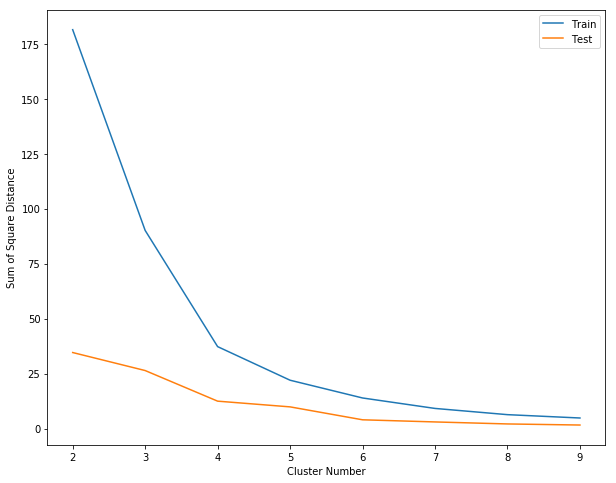

In [46]:
X_train_artist, X_test_artist = df_for_kmeans(artist_group_train, ['Artist_Frequency'])
train_scores, test_scores = kmeans_dist(X_train_artist, X_test_artist, maxk = 10)
plot_kmeans_dist(train_scores, test_scores)

- From the graph above, we could find that cluster number of four is the optimal number

C:\Users\User\Anaconda3\envs\tensorflow_env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


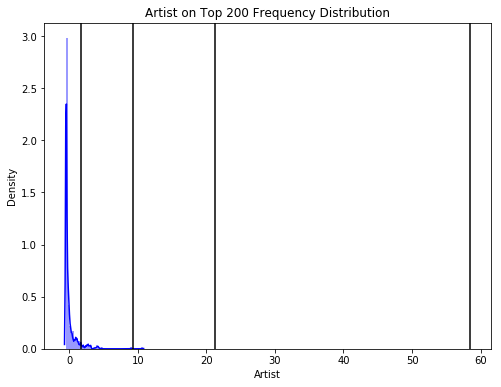

In [47]:
def clustering_artist(data_train, data_test):
    
    """
    Args:
        data (pandas dataframe): Dataset for K-Means
    
    Returns:
        data (pandas dataframe): Dataset with clusters
    """
    
    data_train = data_train.copy()
    data_test = data_test.copy()
    
    # count the frequency by artist
    artist_group_train = pd.DataFrame(data_train.Artist.value_counts())
    artist_group_test = pd.DataFrame(data_test.Artist.value_counts())
    
    # scaling
    Sc = StandardScaler()
    artist_group_train.loc[:, :] = Sc.fit_transform(artist_group_train.astype('float64'))
    artist_group_test.loc[:, :] = Sc.transform(artist_group_test.astype('float64'))
    
    # fit the K-Means with optimal cluster number of 4
    km = KMeans(n_clusters = 4, n_init = 100, random_state = 1)
    
    # cluster for whole dataset
    artist_group_train['Artist_Level'] = km.fit_predict(artist_group_train)
    artist_group_test['Artist_Level'] = km.predict(artist_group_test)
    
    
    # plotting frequency distribution
    fig, ax1 = plt.subplots(1,1, figsize = (8, 6))

    ax1.set_title('Artist on Top 200 Frequency Distribution')
    ax1.set_xlabel('Frequency')
    ax1.set_ylabel('Density')

    sns.distplot(artist_group_train['Artist'],
                 ax = ax1,
                 color = 'blue')

    # plot center for each cluster
    for xc in Sc.inverse_transform(km.cluster_centers_):
    
        plt.axvline(x = xc,
                    color = 'black')
    
    # drop unwanted count
    artist_group_train.drop(['Artist'], axis = 1, inplace = True)
    artist_group_test.drop(['Artist'], axis = 1, inplace = True)
    
    # merge with main dataset for training and test
    data_train = pd.merge(left = data_train,
                          right = artist_group_train,
                          how = 'left',
                          left_on = 'Artist',
                          right_index = True)
    
    data_test = pd.merge(left = data_test,
                         right = artist_group_test,
                         how = 'left',
                         left_on = 'Artist',
                         right_index = True)
    
    # rename the clusters
    data_train['Artist_Level'] = data_train['Artist_Level'].map({2:'Super', 3:'Good', 0:'Intermediate', 1:'Normal'})
    data_test['Artist_Level'] = data_test['Artist_Level'].map({2:'Super', 3:'Good', 0:'Intermediate', 1:'Normal'})
    
    return data_train, data_test

X_train, X_test = clustering_artist(X_train, X_test)

- Drop **Title** and **Artist**

In [48]:
X_train.drop(['Title', 'Artist'], axis = 1, inplace = True)
X_test.drop(['Title', 'Artist'], axis = 1, inplace = True)

# 4. Preprocessing - Stage Two

- Set all numeric value dtype to float

In [49]:
numeric_var = ['acousticness', 'danceability', 'energy', 'liveness',
               'loudness', 'speechiness', 'Tempo', 'valence',
               'verse_num', 'chorus_num', 'verse_len', 'chorus_len',
               'verse_polarity', 'chorus_polarity', 'verse_subjectivity', 'chorus_subjectivity',
               'Lyrics_polarity', 'Lyrics_subjectivity', 'Lyrics_len', 'Lyrics_complexity']


X_train[numeric_var] = X_train[numeric_var].astype('float64')
X_test[numeric_var] = X_test[numeric_var].astype('float64')

- After feature engineering, we need to perform further preprocessing steps before fitting models, such as imputing missing value, feature selection and build sklearn pipeline

### a. Impute missing value

- There are many missing values in artist tag
- Here we just simply use most frequent value to impute missing value
- We will directly implement imputing in pipeline

In [50]:
from sklearn.impute import SimpleImputer

### b. Feature selection

- After feature engineering, there are 56 features in the dataset
- Besides these 56 features, once the TF-IDF matrix is generated from Lyrics, there will be much more features
- So as to reduce the irrelevant noise, we need to perform feature selection before fitting models
- We will use tree-based feature selection method which utilizes information theory to select relevant features
- We will directly implement feature selection in pipeline

In [51]:
print(X_train.shape)

(2503, 56)


In [52]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

### c. Sklearn pipeline

In [53]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

In [54]:
def make_pipeline(modelname, model):
    
    """
    Args:
        modelname (str): The name for the model in pipeline
        model (sklearn model): A sklearn model
    
    Returns:
        pipe (sklearn pipeline): A sklearn pipeline
    """
    
    scaler = StandardScaler()
    onehot = OneHotEncoder(handle_unknown = 'ignore')
    imputer = SimpleImputer(strategy = 'most_frequent')
    tf_idf = TfidfVectorizer()
    
    # categorical variables that need onehot encoded
    category_var = ['releaseYear', 'releaseMonth', 'Lyrics_Topic', 'Artist_Level']
    
    # numeric variables that need to be scaled
    numeric_var = ['acousticness', 'danceability', 'energy', 'liveness',
                   'loudness', 'speechiness', 'Tempo', 'valence',
                   'verse_num', 'chorus_num', 'verse_len', 'chorus_len',
                   'verse_polarity', 'chorus_polarity', 'verse_subjectivity', 'chorus_subjectivity',
                   'Lyrics_polarity', 'Lyrics_subjectivity', 'Lyrics_len', 'Lyrics_complexity']
    
    # variables that need to be imputed (all are from tag)
    imput_var = X_train.columns[(X_train.columns.str.startswith('song') | X_train.columns.str.startswith('art'))].tolist()
    
    
    # build pipeline
    pipe = Pipeline([('columtf', ColumnTransformer(transformers = [('tf_idf_vect', tf_idf, 'Lyrics'),
                                                                   ('scaler', scaler, numeric_var),
                                                                   ('imputer', imputer, imput_var),
                                                                   ('onehot', onehot, category_var)],
                                                   remainder = 'passthrough')),
                     # feature selection using tree
                     ('feature_selection', SelectFromModel(ExtraTreesClassifier(n_estimators = 50))),
                    
                     # model
                     (modelname, model)
                    ])
    
    return pipe

# 5. Models

In [55]:
from sklearn import metrics

def eva(grid, X_train, X_test, y_train, y_test):
    
    y_train_proba = grid.predict_proba(X_train)[:, 1]
    y_train_pred = grid.predict(X_train)
    
    y_test_proba = grid.predict_proba(X_test)[:, 1]
    y_test_pred = grid.predict(X_test)
    
    print('{0:<20}{1:>4.2%}'.format('Training Accuracy: ', metrics.accuracy_score(y_train, y_train_pred)))
    print('{0:<20}{1:>4.2%}'.format('Test Accuracy: ', metrics.accuracy_score(y_test, y_test_pred)))
    
    print('\n{0:<20}{1:>4.2%}'.format('Training AUC: ', metrics.roc_auc_score(y_train, y_train_proba)))
    print('{0:<20}{1:>4.2%}'.format('Test AUC: ', metrics.roc_auc_score(y_test, y_test_proba)))

### a. Logistic Regression

In [56]:
from sklearn.linear_model import LogisticRegression

In [57]:
LR = LogisticRegression(solver = 'liblinear')

- make a pipeline with Logistic Regression

In [58]:
pipeline_lr = make_pipeline('LR', LR)

- use GridSearchCV to tune parameters
- in the param_grid, specify the candidate parameters

- should tune more other candidate value
- however, due to computational limitation, we just list a few here

In [59]:
np.random.seed(1)

param_grid = {}

# parameters for TfidfVectorizer
param_grid['columtf__tf_idf_vect__max_df'] = [0.9]
param_grid['columtf__tf_idf_vect__min_df'] = [5]
param_grid['columtf__tf_idf_vect__ngram_range'] = [(1, 1)]

# parameters for Logistic Regression
param_grid['LR__C'] = 10 ** (2 * np.random.rand(10) - 1)

grid_lr = GridSearchCV(pipeline_lr, 
                       param_grid = param_grid, 
                       cv = 5, 
                       scoring = 'accuracy',
                       return_train_score = True, 
                       verbose = 1, 
                       n_jobs = 2)

- fit the grid with training dataset

In [60]:
grid_lr.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   38.8s
[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:   42.2s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('columtf', ColumnTransformer(n_jobs=None, remainder='passthrough', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('tf_idf_vect', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', in...ty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=2,
       param_grid={'columtf__tf_idf_vect__max_df': [0.9], 'columtf__tf_idf_vect__min_df': [5], 'columtf__tf_idf_vect__ngram_range': [(1, 1)], 'LR__C': array([0.68241, 2.75835, 0.10005, 0.40241, 0.19657, 0.15299, 0.23579,
       0.49105, 0.62163, 1.19573])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=1)

- Best parameters

In [61]:
grid_lr.best_params_

{'LR__C': 0.10005268542378305,
 'columtf__tf_idf_vect__max_df': 0.9,
 'columtf__tf_idf_vect__min_df': 5,
 'columtf__tf_idf_vect__ngram_range': (1, 1)}

In [62]:
eva(grid_lr, X_train, X_test, y_train, y_test)

Training Accuracy:  85.94%
Test Accuracy:      85.18%

Training AUC:       79.36%
Test AUC:           85.23%


### b. SVM

In [63]:
from sklearn.svm import SVC

In [64]:
SVM = SVC(probability = True, random_state = 1)

- make a pipeline with SVM

In [65]:
pipeline_svm = make_pipeline('SVM', SVM)

- use GridSearchCV to tune parameters
- in the param_grid, specify the candidate parameters

- should tune more other candidate value
- however, due to computational limitation, we just list a few here

In [66]:
np.random.seed(1)

param_grid = {}

# parameters for TfidfVectorizer
param_grid['columtf__tf_idf_vect__max_df'] = [0.9]
param_grid['columtf__tf_idf_vect__min_df'] = [5]
param_grid['columtf__tf_idf_vect__ngram_range'] = [(1, 1)]

# parameters for SVM
param_grid = {}
param_grid['SVM__C'] = 10 ** (np.random.rand(5) * 4 - 2)
param_grid['SVM__gamma'] = 10 ** (np.random.rand(5) * 4 - 2)


grid_svm = GridSearchCV(pipeline_svm, 
                        param_grid = param_grid, 
                        cv = 5, 
                        scoring = 'accuracy',
                        return_train_score = True, 
                        verbose = 1, 
                        n_jobs = 2)

- fit the grid with training dataset

In [67]:
grid_svm.fit(X_train, y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  7.8min
[Parallel(n_jobs=2)]: Done 125 out of 125 | elapsed: 20.9min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('columtf', ColumnTransformer(n_jobs=None, remainder='passthrough', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('tf_idf_vect', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', in...='rbf', max_iter=-1, probability=True, random_state=1,
  shrinking=True, tol=0.001, verbose=False))]),
       fit_params=None, iid='warn', n_jobs=2,
       param_grid={'SVM__C': array([0.46568, 7.60848, 0.01001, 0.16193, 0.03864]), 'SVM__gamma': array([0.02341, 0.0556 , 0.24113, 0.38643, 1.42977])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=1)

- Best parameters

In [68]:
grid_svm.best_params_

{'SVM__C': 0.4656804637919565, 'SVM__gamma': 0.02340746480576751}

In [69]:
eva(grid_svm, X_train, X_test, y_train, y_test)

Training Accuracy:  85.26%
Test Accuracy:      85.27%

Training AUC:       99.03%
Test AUC:           76.14%


### c. Random Forest

In [70]:
from sklearn.ensemble import RandomForestClassifier

In [71]:
RF = RandomForestClassifier(n_jobs = -1, random_state = 1)

- make a pipeline with Random Forest

In [72]:
pipeline_rf = make_pipeline('RF', RF)

- use GridSearchCV to tune parameters
- in the param_grid, specify the candidate parameters

- should tune more other candidate value
- however, due to computational limitation, we just list a few here

In [73]:
np.random.seed(1)

param_grid = {}

# parameters for TfidfVectorizer
param_grid['columtf__tf_idf_vect__max_df'] = [0.9]
param_grid['columtf__tf_idf_vect__min_df'] = [5]
param_grid['columtf__tf_idf_vect__ngram_range'] = [(1, 1)]

# parameters for Random Forest
param_grid['RF__n_estimators'] = [100, 200, 300]
param_grid['RF__max_features'] = ['auto', 0.1, 0.3]
param_grid['RF__min_samples_split'] = [40, 60]
param_grid['RF__max_depth'] = [None, 20]

grid_rf = GridSearchCV(pipeline_rf,  
                       param_grid = param_grid, 
                       cv = 5, 
                       scoring = 'accuracy',
                       return_train_score = True,
                       verbose = 1, 
                       n_jobs = 2)

- fit the grid with training dataset

In [74]:
grid_rf.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  1.7min
[Parallel(n_jobs=2)]: Done 180 out of 180 | elapsed: 10.1min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('columtf', ColumnTransformer(n_jobs=None, remainder='passthrough', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('tf_idf_vect', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', in...ators='warn', n_jobs=-1,
            oob_score=False, random_state=1, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=2,
       param_grid={'columtf__tf_idf_vect__max_df': [0.9], 'columtf__tf_idf_vect__min_df': [5], 'columtf__tf_idf_vect__ngram_range': [(1, 1)], 'RF__n_estimators': [100, 200, 300], 'RF__max_features': ['auto', 0.1, 0.3], 'RF__min_samples_split': [40, 60], 'RF__max_depth': [None, 20]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=1)

- Best parameters

In [75]:
grid_rf.best_params_

{'RF__max_depth': 20,
 'RF__max_features': 0.1,
 'RF__min_samples_split': 60,
 'RF__n_estimators': 100,
 'columtf__tf_idf_vect__max_df': 0.9,
 'columtf__tf_idf_vect__min_df': 5,
 'columtf__tf_idf_vect__ngram_range': (1, 1)}

In [76]:
eva(grid_rf, X_train, X_test, y_train, y_test)

Training Accuracy:  85.82%
Test Accuracy:      85.27%

Training AUC:       99.79%
Test AUC:           73.74%


### d. Xgboost

In [77]:
from xgboost import XGBClassifier

In [78]:
XGB = XGBClassifier(n_jobs = -1, random_state = 1)

- make a pipeline with Xgboost

In [79]:
pipeline_xgb = make_pipeline('XGB', XGB)

- use GridSearchCV to tune parameters
- in the param_grid, specify the candidate parameters

- should tune more other candidate value
- however, due to computational limitation, we just list a few here

In [80]:
np.random.seed(1)

param_grid = {}

# parameters for TfidfVectorizer
param_grid['columtf__tf_idf_vect__max_df'] = [0.9]
param_grid['columtf__tf_idf_vect__min_df'] = [5]
param_grid['columtf__tf_idf_vect__ngram_range'] = [(1, 1)]

# parameters for Xgboost
param_grid['XGB__n_estimators'] = [100, 200, 300]
param_grid['XGB__learning_rate'] = [0.01, 0.05, 0.1, 0.2, 0.3]
param_grid['XGB__gamma'] = [0, 0.1, 0.2, 0.3, 0.4]
param_grid['XGB__colsample_bytree'] = [0.5, 0.8]

# param_grid['XGB__max_depth'] =  np.arange(3, 5)
# param_grid['XGB__subsample'] = np.append(np.random.rand(2), 1)


grid_xgb = GridSearchCV(pipeline_xgb, 
                        param_grid = param_grid, 
                        scoring = 'accuracy',
                        cv = 5, 
                        return_train_score = True,
                        verbose = 1, 
                        n_jobs = 2)

- fit the grid with training dataset

In [81]:
grid_xgb.fit(X_train, y_train)

Fitting 5 folds for each of 150 candidates, totalling 750 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  1.3min
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:  5.7min
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed: 13.8min
[Parallel(n_jobs=2)]: Done 750 out of 750 | elapsed: 26.0min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('columtf', ColumnTransformer(n_jobs=None, remainder='passthrough', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('tf_idf_vect', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', in...tate=1, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1))]),
       fit_params=None, iid='warn', n_jobs=2,
       param_grid={'columtf__tf_idf_vect__max_df': [0.9], 'columtf__tf_idf_vect__min_df': [5], 'columtf__tf_idf_vect__ngram_range': [(1, 1)], 'XGB__n_estimators': [100, 200, 300], 'XGB__learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3], 'XGB__gamma': [0, 0.1, 0.2, 0.3, 0.4], 'XGB__colsample_bytree': [0.5, 0.8]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=1)

- Best parameters

In [82]:
grid_xgb.best_params_

{'XGB__colsample_bytree': 0.5,
 'XGB__gamma': 0,
 'XGB__learning_rate': 0.01,
 'XGB__n_estimators': 100,
 'columtf__tf_idf_vect__max_df': 0.9,
 'columtf__tf_idf_vect__min_df': 5,
 'columtf__tf_idf_vect__ngram_range': (1, 1)}

In [83]:
eva(grid_xgb, X_train, X_test, y_train, y_test)

Training Accuracy:  85.26%
Test Accuracy:      85.27%

Training AUC:       84.13%
Test AUC:           78.72%


# 6. Insights

### a. ROC

- ROC and AUC allow us to more generally evaluate the performance of the classifier

In [84]:
from sklearn.metrics import roc_curve, auc

def roc_plot(model, X_data, y_data):
    """
    Args:
        model (list): A list of fitted model
        X_data (pandas dataframe): Data to be predicted
        y_data (pandas series): Target variable
    Returns:
        None
    """
    
    # colors for different
    colors = ['darkorange', 'aqua', 'cornflowerblue', 'red']
    
    # model name
    model_name = ['Logistic', 'SVM', 'RF', 'Xgboost']
    
    # build plotting 
    fig, ax = plt.subplots(1, 1, figsize = (8, 6))
    
    for m, c, mname in zip(model, colors, model_name):
    
        y_score = m.predict_proba(X_data)[:, 1]
    
        # Compute ROC curve and ROC area
        fpr, tpr, _ = roc_curve(y_data.ravel(), y_score.ravel())
        roc_auc = auc(fpr, tpr)
    
        # plot ROC
        lw = 2        
        ax.plot(fpr, tpr, color = c,
                lw = lw, label = '{0:<8} (AUC = {1:.2%})'.format(mname, roc_auc))
        ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('Receiver Operating Characteristic Curve')
        ax.legend(loc = "lower right")

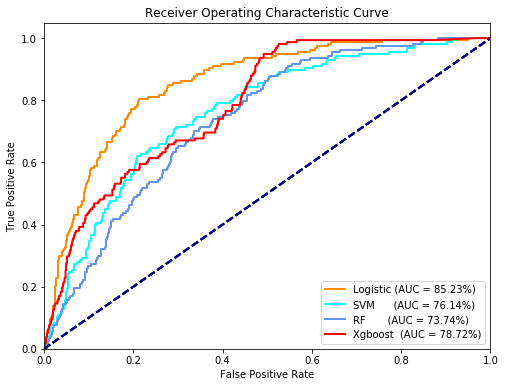

In [85]:
roc_plot([grid_lr, grid_svm, grid_rf, grid_xgb], X_test, y_test)

In [86]:
def model_performance(grid, X_train, X_test, y_train, y_test):
    
    """
    Args:
        model (list): A list of fitted model
        X_train (pandas dataframe): Training data to be predicted
        X_test (pandas dataframe): Test data to be predicted
        y_train (pandas series): Training Target variable
        y_test (pandas series): Test Target variable
        
    Returns:
        performance (pandas series): Dataframe contains performance matrix
    """
    
    # model name
    model_name = ['Logistic', 'SVM', 'RF', 'Xgboost']
    
    # initialize dataframe to store performance
    performance = pd.DataFrame(columns = ['Model', 'Training_Accuracy', 'Test_Accuracy', 'Training_AUC', 'Test_AUC'])
    
    # insert values
    for mod, mname in zip(grid, model_name):
        
        # predict on training set
        y_train_proba = mod.predict_proba(X_train)[:, 1]
        y_train_pred = mod.predict(X_train)
        
        # calculate training performance
        train_acc = metrics.accuracy_score(y_train, y_train_pred)
        train_auc = metrics.roc_auc_score(y_train, y_train_proba)
        
        # predict on test set
        y_test_proba = mod.predict_proba(X_test)[:, 1]
        y_test_pred = mod.predict(X_test)
        
        # calculate test performance
        test_acc = metrics.accuracy_score(y_test, y_test_pred)
        test_auc = metrics.roc_auc_score(y_test, y_test_proba)
        
        # insert value for each model
        performance = performance.append({'Model':mname,
                                          'Training_Accuracy':round(train_acc, 3),
                                          'Test_Accuracy':round(test_acc, 3),
                                          'Training_AUC':round(train_auc, 3),
                                          'Test_AUC':round(test_auc, 3)}, 
                                         ignore_index = True)
        
    performance.set_index('Model', inplace = True)
            
    return performance

In [87]:
performance = model_performance([grid_lr, grid_svm, grid_rf, grid_xgb], X_train, X_test, y_train, y_test)

In [88]:
performance

,Training_Accuracy,Test_Accuracy,Training_AUC,Test_AUC
Model,,,,
Logistic,0.859,0.852,0.794,0.852
SVM,0.853,0.853,0.990,0.761
RF,0.858,0.853,0.998,0.737
Xgboost,0.853,0.853,0.841,0.787


- Surprisingly, logistic regression turns out to be the best model among four
- This could probably be that we do not well tune the parameters for other three models due to computational limitation
- If the best parameters are tuned out, the other three models should be able to perform better

### b. Feature Importance

- From Xgboost we could utilized the feature importance to select the important features

In [89]:
def feature_importance_plot(gird, X_train):
    
    """
    Args:
        grid (sklearn model): A fitted tree-based gridseachcv 
        X_train: Dataset used to fit the model
        
    Returns:
        None
    
    """

    # retrieve columntransformer from grid
    col_tran = gird.best_estimator_.named_steps['columtf']

    # retrieve all column names from each transformer in columntransformer
    tf_idf_vect_colname = col_tran.named_transformers_['tf_idf_vect'].get_feature_names()
    scaler_colname = col_tran.transformers_[1][2]
    imputer_colname = col_tran.transformers_[2][2]
    onehot_colname = col_tran.named_transformers_['onehot'].get_feature_names().tolist()
    remainder_colname = X_train.columns[col_tran.transformers_[-1][2]].tolist()

    # concatenate all
    before_fea_sele_colname = tf_idf_vect_colname + scaler_colname + imputer_colname + onehot_colname + remainder_colname
    before_fea_sele_colname = np.array(before_fea_sele_colname)

    # retrieve feature selector from grid
    feature_selector = gird.best_estimator_.named_steps['feature_selection']
    # retrieve selected features from feature selector
    selected_boolean = feature_selector.get_support()

    # retrieve selected features' name
    feature_selected = before_fea_sele_colname[selected_boolean]

    # get feature importance from grid
    importances = gird.best_estimator_.steps[-1][1].feature_importances_

    # get index by order
    indices = np.argsort(gird.best_estimator_.steps[-1][1].feature_importances_)[-20:]

    # plotting
    fig, ax = plt.subplots(1, 1, figsize = (8, 8))
    ax.barh(np.arange(len(indices)), importances[indices])
    ax.set_yticks(np.arange(len(indices)))
    ax.set_yticklabels(feature_selected[indices])

- All feature importance sums up to 1
- Here we list top 20 features that contribute most to the model prediction
- we could find that the danceability, artist types and some vocabularies contribute more to the model

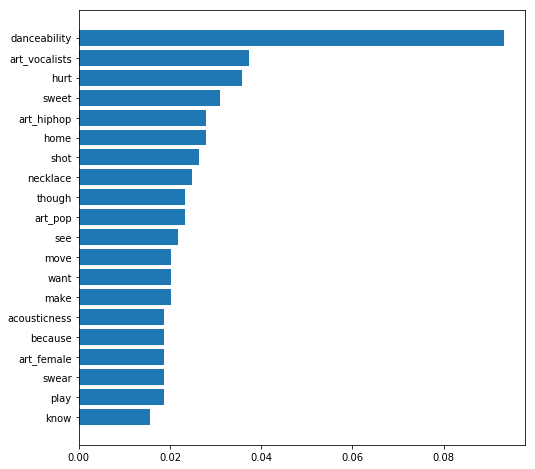

In [90]:
feature_importance_plot(grid_xgb, X_train)

### c. PdpBox

- We could use partial dependency plot to further understand the influence of selected features

In [91]:
from pdpbox import pdp, info_plots

In [92]:
def transformed_data(gird, X_train, X_test):
    
    """
    Args:
        grid (sklearn model): A fitted tree-based gridseachcv 
        X_train: Dataset used to fit the model
        X_test: Dataset used to test the model
        
    Returns:
        X_train_transformed: Training dataset after transformed and feature selection
        X_train_transformed: Test dataset after transformed and feature selection
    """
    
    # retrieve columntransformer from grid
    col_tran = gird.best_estimator_.named_steps['columtf']

    # retrieve all column names from each transformer in columntransformer
    tf_idf_vect_colname = col_tran.named_transformers_['tf_idf_vect'].get_feature_names()
    scaler_colname = col_tran.transformers_[1][2]
    imputer_colname = col_tran.transformers_[2][2]
    onehot_colname = col_tran.named_transformers_['onehot'].get_feature_names().tolist()
    remainder_colname = X_train.columns[col_tran.transformers_[-1][2]].tolist()

    # concatenate all
    before_fea_sele_colname = tf_idf_vect_colname + scaler_colname + imputer_colname + onehot_colname + remainder_colname
    before_fea_sele_colname = np.array(before_fea_sele_colname)

    # retrieve feature selector from grid
    feature_selector = gird.best_estimator_.named_steps['feature_selection']
    # retrieve selected features from feature selector
    selected_boolean = feature_selector.get_support()

    # retrieve selected features' name
    feature_selected = before_fea_sele_colname[selected_boolean]

    # get transformed dataset
    X_train_transformed = pd.DataFrame(feature_selector.transform(col_tran.transform(X_train)).toarray(),
                                       columns = feature_selected)
    X_test_transformed = pd.DataFrame(feature_selector.transform(col_tran.transform(X_test)).toarray(),
                                      columns = feature_selected)
    
    return X_train_transformed, X_test_transformed

X_train_transformed, X_test_transformed = transformed_data(grid_xgb, X_train, X_test)

- fit xgboost model again using the best parameter for pdp

In [93]:
grid_xgb.best_params_

{'XGB__colsample_bytree': 0.5,
 'XGB__gamma': 0,
 'XGB__learning_rate': 0.01,
 'XGB__n_estimators': 100,
 'columtf__tf_idf_vect__max_df': 0.9,
 'columtf__tf_idf_vect__min_df': 5,
 'columtf__tf_idf_vect__ngram_range': (1, 1)}

In [94]:
xgb_pdp = XGBClassifier(n_estimators = 100,
                        learning_rate = 0.01,
                        gamma = 0,
                        colsample_bytree = 0.5,
                        random_state = 1,
                        n_jobs = -1)

xgb_pdp.fit(X_train_transformed, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=1, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

- pdp of **danceability**, the more the danceability the higher the probability of being popular 

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1d4410359b0>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1d4414de940>})

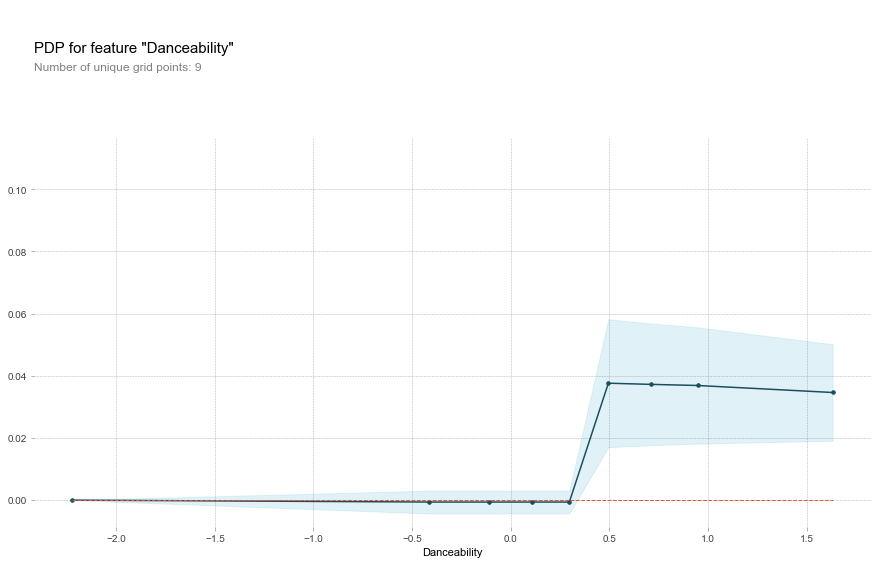

In [95]:
pdp_dan = pdp.pdp_isolate(model = xgb_pdp,
                          dataset = X_test_transformed, 
                          model_features = X_test_transformed.columns.tolist(),
                          feature = 'danceability')

pdp.pdp_plot(pdp_dan, 'Danceability')

- pdp of **art_vocalists**, if the artist is vocalist the higher the probability of being popular 

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1d440bfb780>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1d4410c8dd8>})

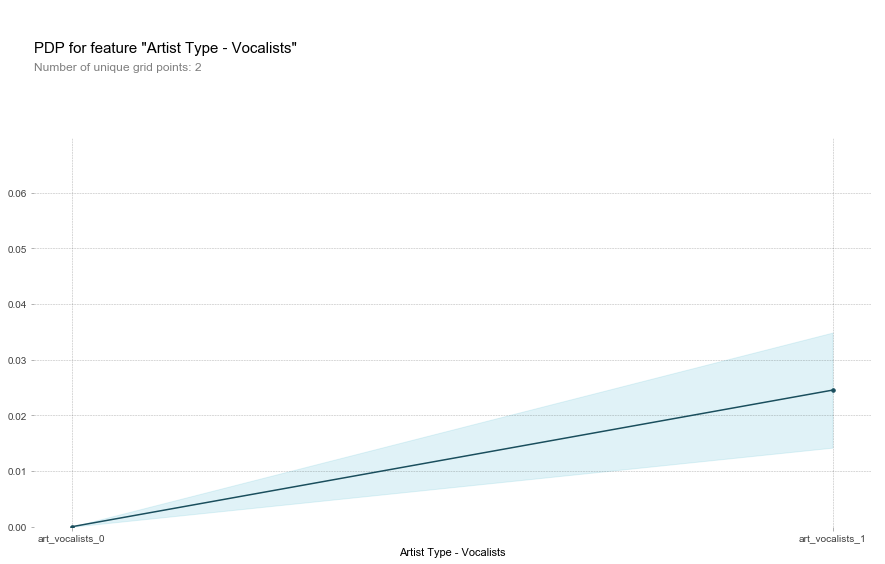

In [96]:
pdp_voc = pdp.pdp_isolate(model = xgb_pdp, 
                          dataset = X_test_transformed, 
                          model_features = X_test_transformed.columns.tolist(),
                          feature = 'art_vocalists')

pdp.pdp_plot(pdp_voc, 'Artist Type - Vocalists')

- pdp of **hurt**, if the song contains the word hurt the higher the probability of being popular

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1d440e76ef0>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1d440e202b0>})

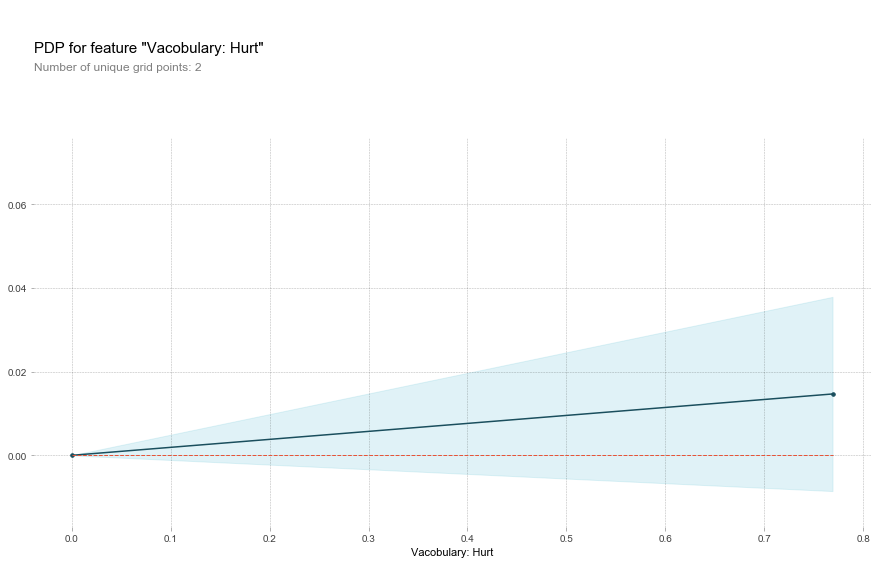

In [97]:
pdp_dan = pdp.pdp_isolate(model = xgb_pdp,
                          dataset = X_test_transformed, 
                          model_features = X_test_transformed.columns.tolist(),
                          feature = 'hurt')

pdp.pdp_plot(pdp_dan, 'Vacobulary: Hurt')